<a href="https://colab.research.google.com/github/BenjaminUy/Predicting-Loan-User-Default-Risk/blob/main/notebooks/Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **India Loan Users - Model Development**
Notebook creator: Benjamin Uy

Date created: 6/30/2025

---
Introduction: This is my Jupyter notebook for model development on a dataset of loan customers from India.

The dataset I will use is a modifed and cleaned version of Kaggle user Subham Surana's "Loan Prediction Based on Customer Behavior" (link below). The purpose of creating a model is to accurately predict, given the details of the customer, whether they will default on their loan -- indicated by the 'Risk_Flag' variable.

Link to original dataset: https://www.kaggle.com/datasets/subhamjain/loan-prediction-based-on-customer-behavior?select=Training+Data.csv

Link to modified dataset: https://github.com/BenjaminUy/Predicting-Loan-User-Default-Risk/blob/main/datasets/loan_users_cleaned.csv

In [1]:
import pandas as pd

# Read in the cleaned dataset
url = 'https://raw.githubusercontent.com/BenjaminUy/Predicting-Loan-User-Default-Risk/refs/heads/main/datasets/loan_users_cleaned.csv'
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 34 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Income                              252000 non-null  int64
 1   Age                                 252000 non-null  int64
 2   Experience                          252000 non-null  int64
 3   Is_Married                          252000 non-null  int64
 4   House_Ownership_Ordinal             252000 non-null  int64
 5   Owns_Car                            252000 non-null  int64
 6   CURRENT_JOB_YRS                     252000 non-null  int64
 7   CURRENT_HOUSE_YRS                   252000 non-null  int64
 8   Risk_Flag                           252000 non-null  int64
 9   Above_Income_Threshold              252000 non-null  int64
 10  Sector_Architecture & Construction  252000 non-null  int64
 11  Sector_Aviation & Transportation    252000 non-null 

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop('Risk_Flag', axis=1)
y = df['Risk_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=123, stratify=y)

print("X_train size: ", X_train.shape)
print("X_test size: ", X_test.shape)
print("y_train size: ", y_train.shape)
print("y_test size: ", y_test .shape)

X_train size:  (201600, 33)
X_test size:  (50400, 33)
y_train size:  (201600,)
y_test size:  (50400,)


In [5]:
# Check proportion of Risk_Flag in both datasets
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Risk_Flag
0    0.876999
1    0.123001
Name: proportion, dtype: float64
Risk_Flag
0    0.877004
1    0.122996
Name: proportion, dtype: float64


### Random Forest Approach

In [7]:
'''
Given the large amount of data I am working with, along with the
model's ability to better generalize, I will use a random forest.
Let's see how the base model performs.
'''

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Accuracy: 90.00%
Precision: 60.81%
Recall: 52.61%
F1 Score: 56.41%


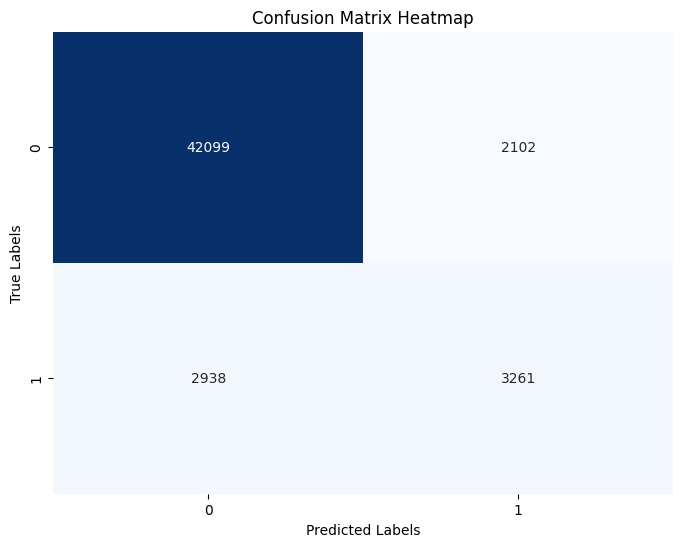

In [10]:
# Checking various score metrics and outputting confusion matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, y_pred) * 100:.2f}%")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=y.unique(), yticklabels=y.unique())

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

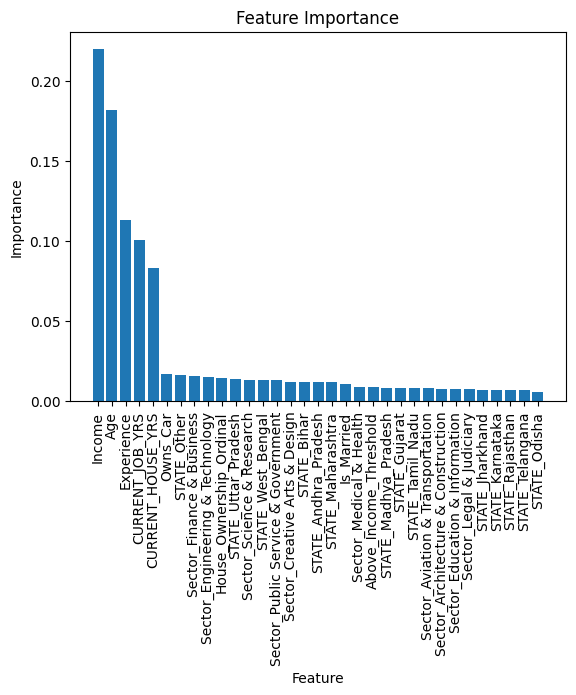

In [16]:
# Checking what are the most important features in the model
feature_importances = clf.feature_importances_

importances_df = pd.DataFrame({'Feature' : X.columns, 'Importance' : feature_importances})
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.bar(importances_df['Feature'], importances_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

From the feature importances graph, it appears the Sector_*, STATE_*, Owns_Car, and Above_Income_Threshold are not as important compared to Income and Age.

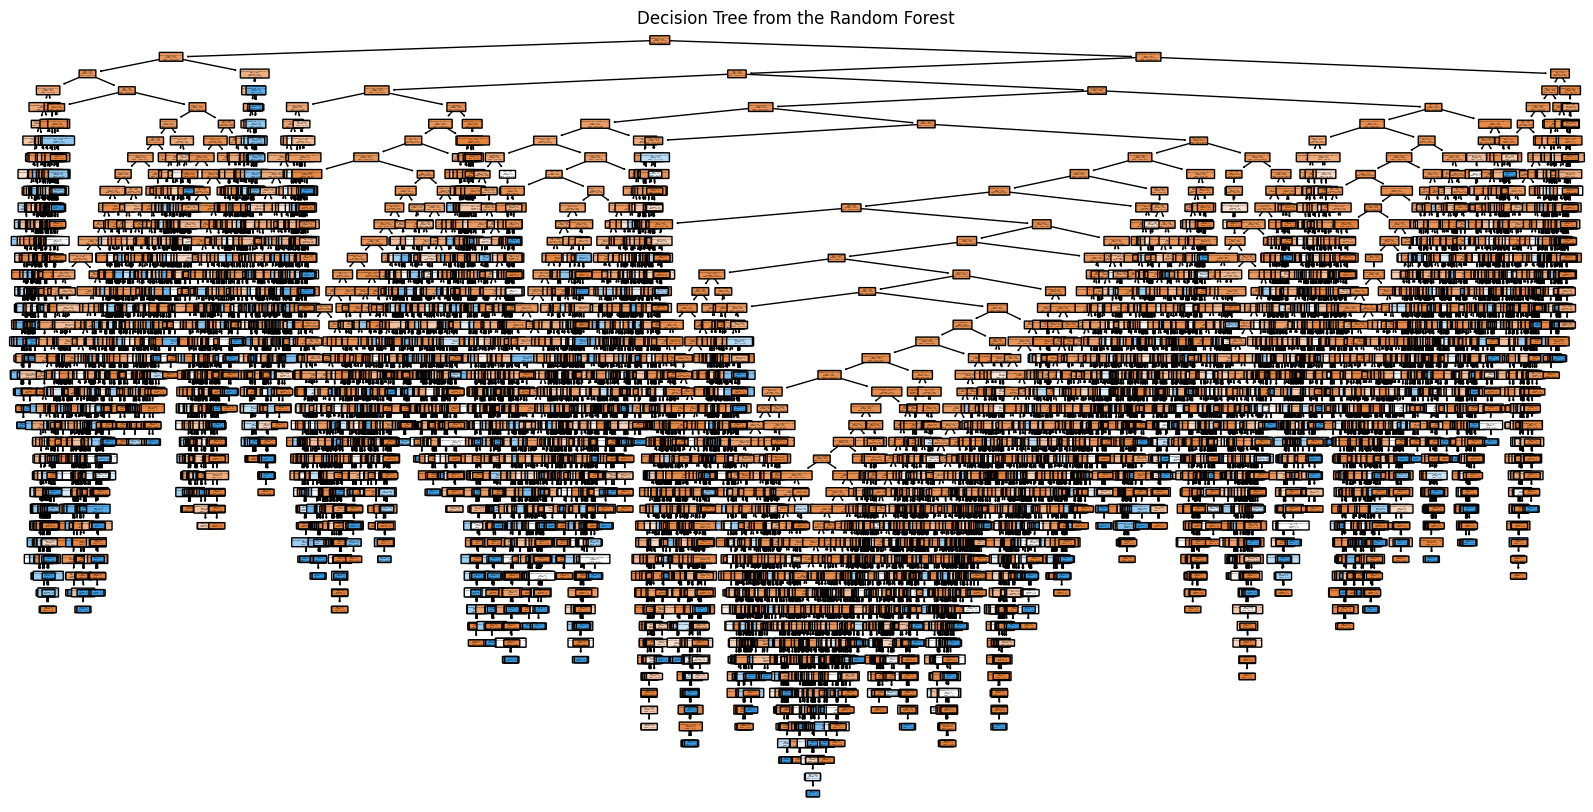

In [20]:
# Visualize one of the decision trees in this random forest

from sklearn.tree import plot_tree

tree = clf.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(tree,
          feature_names=X.columns,
          class_names=['Non-defaulter', 'Defaulter'],
          filled=True,
          rounded=True)
plt.title("Decision Tree from the Random Forest")
plt.show()

In [24]:
# Let's try feature selection using the top N important features

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Here, assume the best N is the one with the best accuracy
best_N = 1
for i in range(1, importances_df.shape[0]):
  # Select the top N important features
  N = i
  top_n_features = importances_df[:N]['Feature']
  X_train_selected = X_train[top_n_features]
  X_test_selected = X_test[top_n_features]

  # Create the random forest model
  clf_selected = RandomForestClassifier(random_state=123)
  clf_selected.fit(X_train_selected, y_train)
  y_pred_selected = clf_selected.predict(X_test_selected)

  # Evaluate scores and determine if the accuracy score improves
  accuracy_scores.append(accuracy_score(y_test, y_pred_selected))
  precision_scores.append(precision_score(y_test, y_pred_selected))
  recall_scores.append(recall_score(y_test, y_pred_selected))
  f1_scores.append(f1_score(y_test, y_pred_selected))

  if accuracy_scores[-1] > accuracy_scores[best_N - 1]:
    best_N = i

print(f"Best N: {best_N}")

Best N: 27


In [42]:
# Let's use grid search and cross validation to optimize the model
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=123)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

KeyboardInterrupt: 

### XGBoost Approach

In [45]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [20, 25, 30],
    'learning_rate': [0.01, 0.1, 0.001],
    'subsample': [0.5, 0.7, 1]
}

model = xgb.XGBClassifier(random_state=123)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 30, 'subsample': 0.5}
Best score found:  0.8981101190476191


Accuracy: 88.68%
Precision: 65.50%
Recall: 16.87%
F1 Score: 26.83%


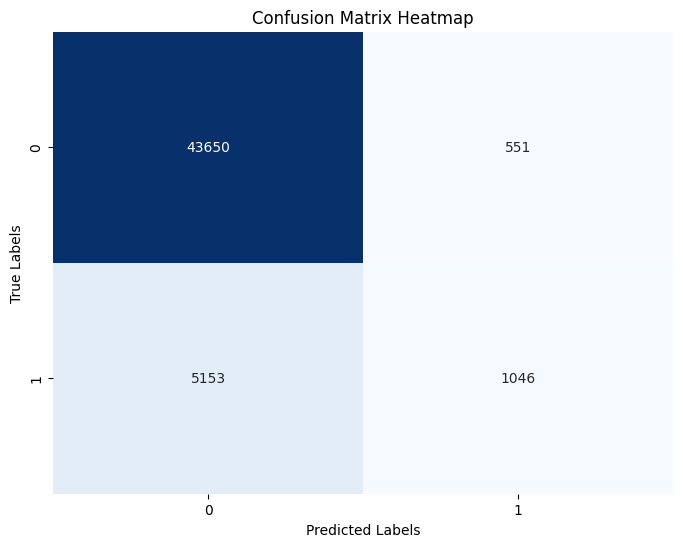

In [44]:
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, y_pred) * 100:.2f}%")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=y.unique(), yticklabels=y.unique())

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()